In [4]:
%matplotlib inline
import os
import cPickle as pickle
import numpy as np
import cv2
from incisorseg.dataset import Dataset,LeaveOneOutSplitter,appearance_model_eight_teeth,appearance_model_four_teeth,load_image,load_landmark,gaussian_pyramid_down,tooth_splitter,tooth_models,gaussian_pyramid_up
from incisorseg.utils import *
from active_shape_models.models import GreyModel,PointDistributionModel,ActiveShapeModel
from active_shape_models.shape import Shape, ShapeList,LineGenerator
import json
data = Dataset('../data/')
def get_grey_models(data,modelfileprefix,train_width):
    fname = modelfileprefix + '_default_'+str(train_width)+'.dat'
    if os.path.isfile(fname):
        f = open(fname)
        gms = pickle.load(f)
        f.close()
        return gms
    else:
        gms = []
        for index,split in enumerate(LeaveOneOutSplitter(data,Dataset.ALL_TRAINING_IMAGES,Dataset.ALL_TEETH)):
            training_images,training_landmarks,_ = split.get_training_set()
            test_image,test_landmark,_ = split.get_test_example()
            gms.append(GreyModel(training_images,training_landmarks,train_width,50))
        f = open(fname, 'w')
        pickle.dump(gms,f)
        f.close()
        return gms

gms = get_grey_models(data,'picklegms',15)

In [6]:
class AppearanceModel:
    """
        An appearance model used to quickly find an initial solution using
        normalized cross correlation based template matching in a zone restricted
        by the centroid of the training shapes
        Attributes:
            _template: The template generated from the training_images
            _init_shape: The centroid used by the PDM for initialization
            _extent_scale: The [x,y] scaling factor to control the mask for template search


        Authors: David Torrejon and Bharath Venkatesh
    """

    def _build_template(self, training_images, pdm):
        """
        Builds the template that need to be matched
        :param training_images: The set of training images
        :param pdm: A point distribution model built from the corresponding landmarks
        """
        landmarks = pdm.get_shapes()
        all_bbox = landmarks.get_mean_shape().center().scale(self._template_scale).translate(
            landmarks.get_mean_shape().get_centroid()).get_bounding_box()
        patch_size = np.squeeze(np.uint32(np.round(np.diff(all_bbox, axis=0))))
        datalist = []
        for j in range(len(landmarks)):
            shape_bbox = np.uint32(np.round(landmarks[j].center().scale(self._template_scale).translate(
                landmarks[j].get_centroid()).get_bounding_box()))
            cropped = training_images[j][shape_bbox[0, 1]:shape_bbox[1, 1], shape_bbox[0, 0]:shape_bbox[1, 0]]
            img = cv2.resize(cropped, (patch_size[0], patch_size[1]))
            datalist.append(img)
        self._template = np.uint8(np.mean(np.array(datalist), axis=0))
    
    def get_default_shape(self):
        return self._centroid_shape

    def get_template(self):
        return self._template

    def _build_search_mask(self, test_size, corrmap_size):
        """
        Builds a mask controlled by extent_scale to restrict the zone of template search
        :param test_size: The size of the test_image
        :return: The mask image
        """
        if corrmap_size == test_size:
            mask = np.uint8(np.zeros(test_size))
            reccord = np.uint32(np.round(self._init_shape.get_bounding_box()))
            extent = np.squeeze(
                np.uint32(np.round(np.diff(np.float32(reccord), axis=0) / np.array(self._extent_scale))))
            cv2.rectangle(mask, (reccord[0, 0] - extent[0], reccord[0, 1] - extent[1]),
                          (reccord[0, 0] + extent[0], reccord[0, 1] + extent[1]), (255, 0, 0), -1)
            return mask
        else:
            hh, ww = test_size
            h, w = self._template.shape
            mask = np.uint8(np.zeros((hh - h + 1, ww - w + 1)))
            reccord = np.uint32(np.round(self._init_shape.get_bounding_box()))
            extent = np.squeeze(
                np.uint32(np.round(np.diff(np.float32(reccord), axis=0) / np.array(self._extent_scale))))
            mask[(reccord[0, 1] - extent[1]):(
                reccord[0, 1] + extent[1]), (reccord[0, 0] - extent[0]):(reccord[0, 0] + extent[0])] = 1
            return mask

    def __init__(self, training_images, pdm, extent_scale, template_scale, metric=5):
        """
        Builds an appearance model
        :param training_images: The set of training images
        :param pdm: A point distribution model built from the corresponding landmarks
        :param extent_scale:  The [x,y] scaling factor to control the mask for template search
        """
        self._init_shape = pdm.get_mean_shape_projected()
        self._template_scale = template_scale
        self._build_template(training_images, pdm)
        self._extent_scale = extent_scale
        self._centroid_shape = pdm.get_mean_shape_projected()
        self._metric = metric

    def fit(self, test_image):
        """
        Perform the template matching operation to identify the initial shape
        :param test_image: The test image
        :return: Shape corressponding to the match and the metric value
        """
        h, w = self._template.shape
        ret = cv2.matchTemplate(test_image, self._template, method=self._metric)
        mask = self._build_search_mask(test_image.shape, ret.shape)
        if ret.shape == test_image.shape:
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(ret, mask=mask)
        else:
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(np.multiply(ret,mask))
        if self._metric == 0 or self._metric == 1:
            loc = min_loc
            val = -min_val
        else:
            loc = max_loc
            val = max_val
        translation = loc + np.round([w / 2.0, h / 2.0])
        return self._init_shape.center().translate(translation),val

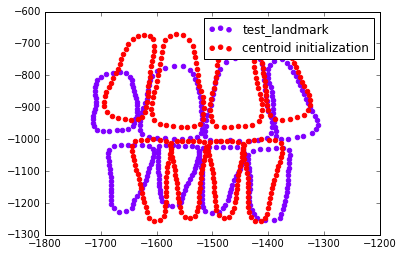

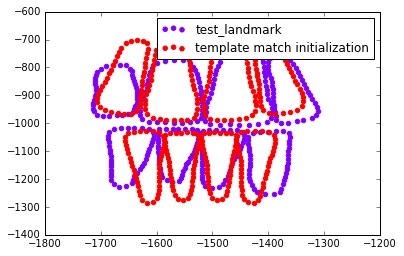

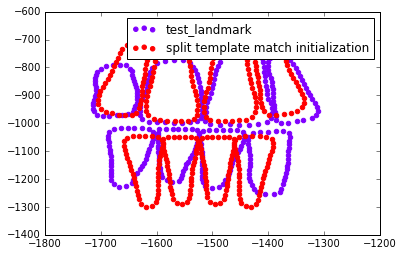

Initialization 0.47267896679 0.544836173732 0.53044495766


In [ ]:
i = 0
for index,split in enumerate(LeaveOneOutSplitter(data,Dataset.ALL_TRAINING_IMAGES,Dataset.ALL_TEETH)):
    training_images,training_landmarks,training_segmentations = split.get_training_set()
    test_image,test_landmark,big_test_segmentation = split.get_test_example()
    transformed_test_image = test_image
    transformed_training_images = training_images
    #transformed_training_images = [cv2.medianBlur(image,5) for image in transformed_training_images]
    #transformed_training_images = [cv2.equalizeHist(image) for image in transformed_training_images]
    split_training_landmarks = tooth_splitter(training_landmarks,2)
    all_split_training_landmarks = tooth_splitter(training_landmarks,8)
    two_upper_teeth = all_split_training_landmarks[1]
    two_lower_teeth = all_split_training_landmarks[5]
    ltl=[]
    utl = []
    mtl = []
    for i in range(len(all_split_training_landmarks[0])):
        ashape = all_split_training_landmarks[1][i].concatenate(all_split_training_landmarks[2][i])
        bshape = all_split_training_landmarks[5][i].concatenate(all_split_training_landmarks[6][i])
        cshape = ashape.concatenate(bshape)
        utl.append(ashape)
        ltl.append(bshape)
        mtl.append(cshape)
    two_upper_teeth=ShapeList(utl)
    two_lower_teeth=ShapeList(ltl)
    four_middle_teeth = ShapeList(mtl)
    #transformed_test_image = cv2.medianBlur(transformed_test_image,5)
    #transformed_test_image = cv2.equalizeHist(transformed_test_image)
    shape_model = PointDistributionModel(training_landmarks,pca_variance_captured=0.99,use_transformation_matrix=True,project_to_tangent_space=True)
    upper_shape_model = PointDistributionModel(split_training_landmarks[0],pca_variance_captured=0.99,use_transformation_matrix=True,project_to_tangent_space=True)
    lower_shape_model = PointDistributionModel(split_training_landmarks[1],pca_variance_captured=0.99,use_transformation_matrix=True,project_to_tangent_space=True)
    #upper_shape_model2 = PointDistributionModel(two_upper_teeth,pca_variance_captured=0.99,use_transformation_matrix=True,project_to_tangent_space=True)
    #lower_shape_model2 = PointDistributionModel(two_lower_teeth,pca_variance_captured=0.99,use_transformation_matrix=True,project_to_tangent_space=True)
    #middle_shape_model = PointDistributionModel(four_middle_teeth,pca_variance_captured=0.99,use_transformation_matrix=True,project_to_tangent_space=True)
    grey_model = gms[index]
    #grey_model = GreyModel(transformed_training_images, training_landmarks,patch_num_pixels_length=10,patch_num_pixels_width=10,
    #                       search_num_pixels=60,use_template_match=False, use_laplacian=False,use_gradient=True,
    #             normalize_patch=True, use_moded_pca_model=False, mpca_variance_captured=0.9,
    #             normal_point_neighborhood=2)
    active_shape_model = ActiveShapeModel(shape_model,grey_model)
    appearance_model = AppearanceModel(transformed_training_images,shape_model,[1,1],[1.1,1.5],5)
    #imshow2(appearance_model.get_template())
    upper_appearance_model = AppearanceModel(transformed_training_images,upper_shape_model,[1,1],[1.1,1.5],5)
    #imshow2(upper_appearance_model.get_template())
    lower_appearance_model = AppearanceModel(transformed_training_images,lower_shape_model,[1,1],[1.1,1.5],5)
    #imshow2(lower_appearance_model.get_template())
    #upper_appearance_model2 = AppearanceModel(transformed_training_images,upper_shape_model2,[1.8,1.8],[1.7,1.7],5)
    #lower_appearance_model2 = AppearanceModel(transformed_training_images,lower_shape_model2,[1.8,1.8],[1.7,1.7],5)
    #middle_appearance_model = AppearanceModel(transformed_training_images,middle_shape_model,[1.8,1.8],[1.7,1.7],5)
    #new_shape,_= grey_model.search(transformed_test_image,test_landmark)
    #newer_shape,_,_ = shape_model.fit(new_shape)
    #newest_shape,_,_ = active_shape_model.fit(transformed_test_image,initial_shape=test_landmark)
    centroid_shape = appearance_model.get_default_shape()
    upper_centroid_shape = upper_appearance_model.get_default_shape()
    lower_centroid_shape = lower_appearance_model.get_default_shape()
    appearance_shape,val = appearance_model.fit(transformed_test_image)
    upper_appearance_shape,upper_val = upper_appearance_model.fit(transformed_test_image)
    lower_appearance_shape,lower_val = lower_appearance_model.fit(transformed_test_image)
    #upper_appearance_shape2,upper_val2 = upper_appearance_model2.fit(transformed_test_image)
    #lower_appearance_shape2,lower_val2 = lower_appearance_model2.fit(transformed_test_image)
    #middle_appearance_shape,val4 = middle_appearance_model.fit(transformed_test_image)
    #moved_upper_appearance_shape = upper_appearance_shape.center().translate(upper_appearance_shape2.get_centroid())
    #moved_lower_appearance_shape = lower_appearance_shape.center().translate(lower_appearance_shape2.get_centroid())
    #moved_middle_shape = appearance_shape.center().translate(middle_appearance_shape.get_centroid())
    #val2 = (0.5*upper_val+0.5*lower_val)
    #val3 = (0.5*upper_val2+0.5*lower_val2)
    appearance_shape2 = upper_appearance_shape.concatenate(lower_appearance_shape)
    #appearance_shape3 = moved_upper_appearance_shape.concatenate(moved_lower_appearance_shape)
    plot_shapes([test_landmark,centroid_shape],labels=['test_landmark','centroid initialization'])
    plot_shapes([test_landmark,appearance_shape],labels=['test_landmark','template match initialization'])
    plot_shapes([test_landmark,appearance_shape2],labels=['test_landmark','split template match initialization'])
    print 'Initialization',split.get_dice_error_on_test(centroid_shape),split.get_dice_error_on_test(appearance_shape),split.get_dice_error_on_test(appearance_shape2)
    #plot_shapes([test_landmark,newest_shape])
    #print split.get_dice_error_on_test(new_shape),split.get_dice_error_on_test(newer_shape),split.get_dice_error_on_test(newest_shape),split.get_dice_error_on_test(centroid_shape),split.get_dice_error_on_test(appearance_shape)
    #error_list.append(split.get_dice_error_on_test(newest_shape))
    newest_shape0,_,_ = active_shape_model.fit(transformed_test_image,initial_shape=centroid_shape,tol=0.2, max_iters=10)
    newest_shape1,_,_ = active_shape_model.fit(transformed_test_image,initial_shape=appearance_shape,tol=0.2, max_iters=10)
    newest_shape2,_,_ = active_shape_model.fit(transformed_test_image,initial_shape=appearance_shape2,tol=0.2, max_iters=10)
    newest_shape3,_,_ = active_shape_model.fit(transformed_test_image,initial_shape=test_landmark,tol=0.2, max_iters=10)
    plot_shapes([test_landmark,newest_shape0],labels=['test_landmark','asm with centroid initialization'])
    plot_shapes([test_landmark,newest_shape1],labels=['test_landmark','asm with template match initialization'])
    plot_shapes([test_landmark,newest_shape2],labels=['test_landmark','asm with split template match initialization'])
    plot_shapes([test_landmark,newest_shape3],labels=['test_landmark','asm with manual initialization'])
    print 'ASM',split.get_dice_error_on_test(newest_shape0),split.get_dice_error_on_test(newest_shape1),split.get_dice_error_on_test(newest_shape2),split.get_dice_error_on_test(newest_shape3)    
    #newest_shape3,_,_ = active_shape_model.fit(transformed_test_image,initial_shape=appearance_shape3)
    #newest_shape4,_,_ = active_shape_model.fit(transformed_test_image,initial_shape=moved_middle_shape)
    #plot_shapes([test_landmark,centroid_shape,newest_shape0])
    #plot_shapes([test_landmark,appearance_shape,newest_shape1])
    #plot_shapes([test_landmark,appearance_shape2,newest_shape2])
    #plot_shapes([test_landmark,appearance_shape3,newest_shape3])
    #plot_shapes([test_landmark,moved_middle_shape,newest_shape4])
    
    #print split.get_dice_error_on_test(centroid_shape),split.get_dice_error_on_test(appearance_shape),split.get_dice_error_on_test(appearance_shape2),split.get_dice_error_on_test(appearance_shape3),split.get_dice_error_on_test(moved_middle_shape)
    
    i = i+1
    if i >= 1:
        pass#break
#print np.mean(np.array(error_list))

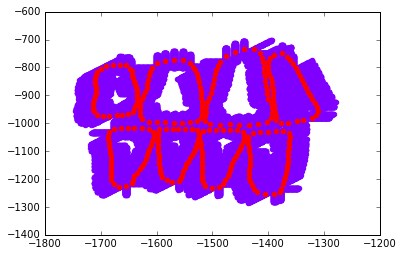

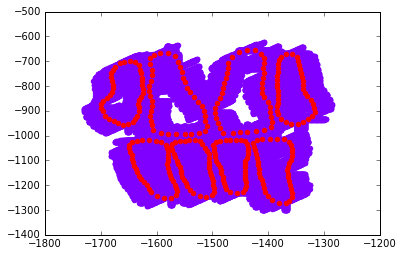

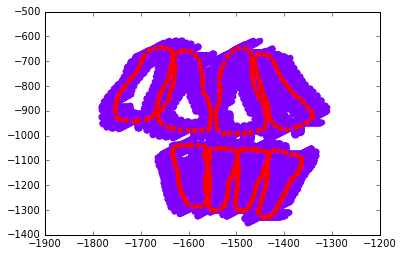

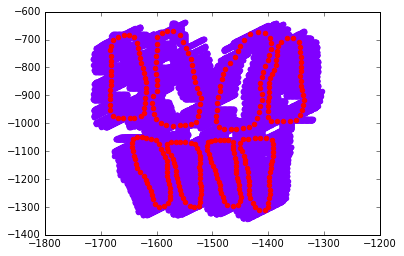

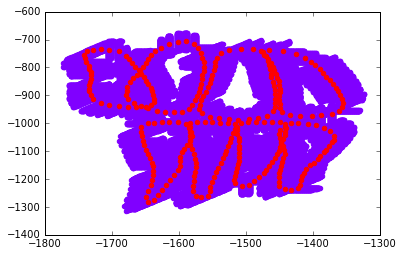

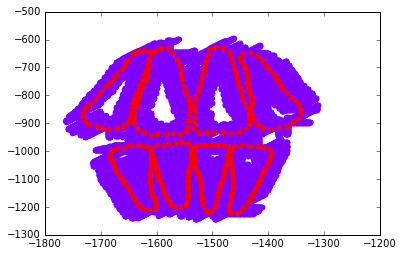

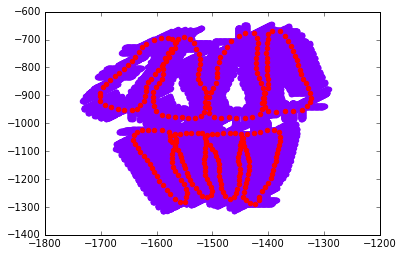

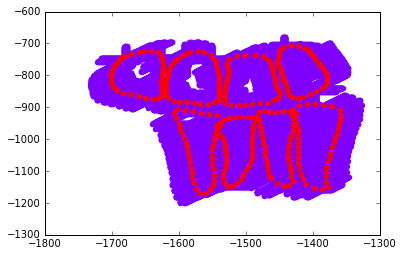

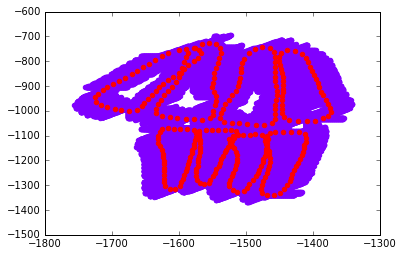

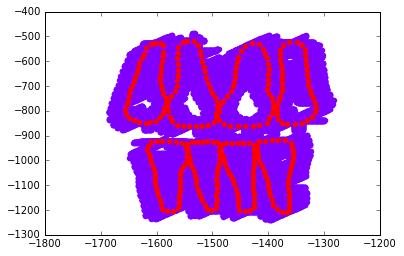

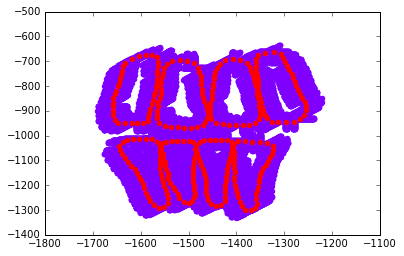

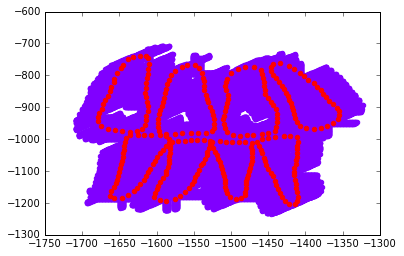

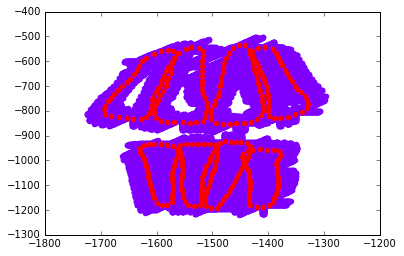

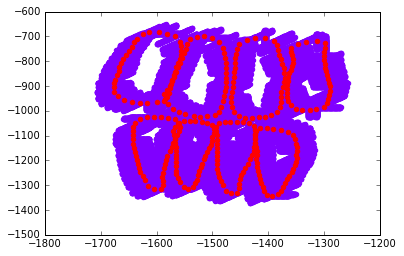

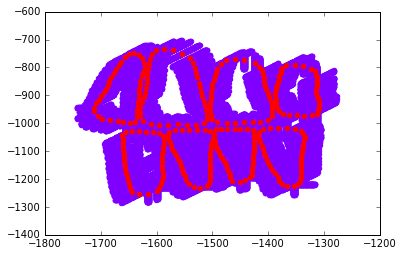

In [15]:
for split in LeaveOneOutSplitter(data,Dataset.ALL_TRAINING_IMAGES,Dataset.ALL_TEETH):
    training_images,training_landmarks,training_segmentations = split.get_training_set()
    test_image,test_landmark,big_test_segmentation = split.get_test_example()
    normal_points = []
    for point_index in range(test_landmark.get_size()):
        point = test_landmark.get_point(point_index)
        tangent_slope_vector, normal_slope_vector = test_landmark.get_slope_vectors_at_point(point_index,4)
        normal_coordinates_generator = LineGenerator(point, normal_slope_vector)
        normal_coordinate_list = normal_coordinates_generator.generate_two_sided(30)
        for coordinates in normal_coordinate_list:
            tangent_coordinates_generator = LineGenerator(coordinates, tangent_slope_vector)
            tangent_coordinate_list=tangent_coordinates_generator.generate_two_sided(2)
            normal_points = normal_points + tangent_coordinate_list
    plot_shapes([Shape(np.array(normal_points)),test_landmark])

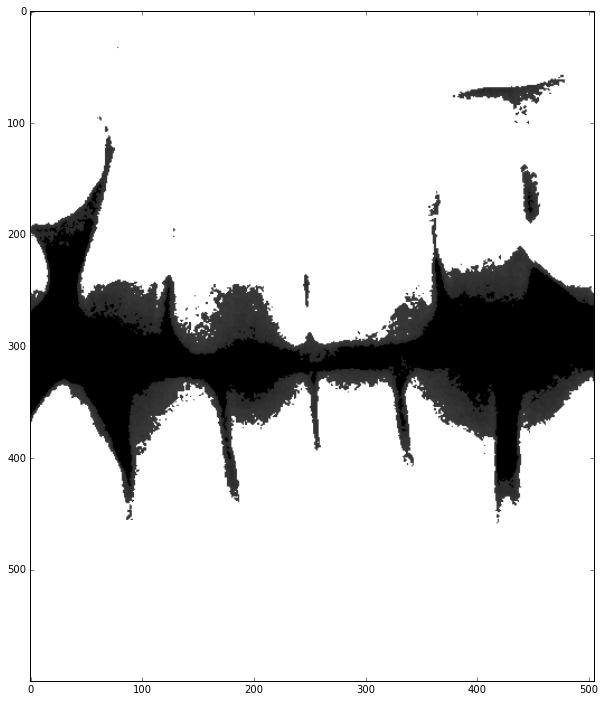

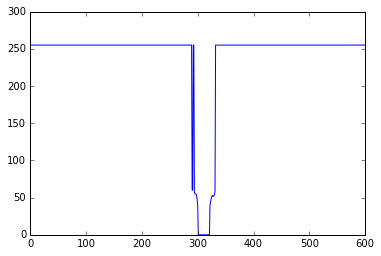

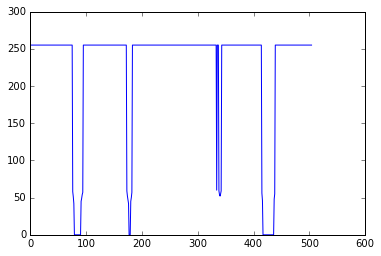

In [71]:
for index,split in enumerate(LeaveOneOutSplitter(data,Dataset.ALL_TRAINING_IMAGES,Dataset.ALL_TEETH)):
    if index > 0:
        break
    training_images,training_landmarks,training_segmentations = split.get_training_set()
    test_image,test_landmark,big_test_segmentation = split.get_test_example()
    roi2 = test_image[700:1300,1270:1775]
    #roi = cv2.medianBlur(roi,1)
    #roi = cv2.Laplacian(roi,cv2.CV_16U,ksize=9)
    #roi[roi>60] = 255
    imshow2(roi2)
    plot_line(roi2[:,300])
    plot_line(roi2[400,:])
    #kernel = np.ones((400,400),np.uint8)

    #tophat = cv2.morphologyEx(roi, cv2.MORPH_TOPHAT, kernel)
    #imshow2(10*tophat)
    #plot_line(tophat[:,300])
    #plot_line(tophat[400,:])